In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shouviksen27","key":"ec6d7ae56f7d6517c32cd53f1e71065f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d robinreni/signature-verification-dataset

Dataset URL: https://www.kaggle.com/datasets/robinreni/signature-verification-dataset
License(s): CC0-1.0
100% 601M/601M [00:09<00:00, 79.7MB/s]
100% 601M/601M [00:09<00:00, 63.2MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/signature-verification-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

In [ ]:
base_dir = "/content/sign_data/train/"

# Load CSV files
def load_data(csv_path):
    df = pd.read_csv(csv_path, header=None)
    df.columns = ["real_signature_path", "test_signature_path", "label"]
    return df

train_df = load_data("/content/sign_data/train_data.csv")
test_df = load_data("/content/sign_data/test_data.csv")

In [ ]:
def load_image(image_path):
    full_path = os.path.join(base_dir, image_path)
    img = cv2.imread(full_path)  # Keep original color
    if img is None:
        print(f"Warning: Could not read image {full_path}")
        return None
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Normalize
    return img

In [ ]:
class SignatureDataGenerator(Sequence):
    def __init__(self, df, batch_size=16):
        self.df = df
        self.batch_size = batch_size
        self.indices = np.arange(len(df))

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X1, X2, Y = [], [], []

        for i in batch_indices:
            row = self.df.iloc[i]
            imgA = load_image(row["real_signature_path"])
            imgB = load_image(row["test_signature_path"])
            label = row["label"]

            if imgA is not None and imgB is not None:
                X1.append(imgA)
                X2.append(imgB)
                Y.append(label)

        return (np.array(X1, dtype=np.float32), np.array(X2, dtype=np.float32)), np.array(Y, dtype=np.float32)


In [ ]:

# Create data generators
train_generator = SignatureDataGenerator(train_df, batch_size=16)
test_generator = SignatureDataGenerator(test_df, batch_size=16)


In [ ]:
def build_mobilenet_base():
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights="imagenet")
    for layer in base_model.layers:
        layer.trainable = False
    return base_model

# Define a function to compute Euclidean distance
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

# Build Siamese MobileNetV2 model
def build_siamese_mobilenet():
    mobilenet_base = build_mobilenet_base()

    input_a = Input(shape=(224, 224, 3))
    input_b = Input(shape=(224, 224, 3))

    processed_a = mobilenet_base(input_a)
    processed_b = mobilenet_base(input_b)

    distance = Lambda(euclidean_distance)([processed_a, processed_b])

    output = Dense(1, activation="sigmoid")(distance)

    model = Model([input_a, input_b], output)
    return model


In [ ]:
# Build and compile Siamese model
siamese_model = build_siamese_mobilenet()
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train and evaluate the model
history = siamese_model.fit(train_generator, epochs=10, validation_data=test_generator)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 258s 168ms/step - accuracy: 0.4791 - loss: 0.7257 - val_accuracy: 0.5209 - val_loss: 0.6679
Epoch 2/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 228s 157ms/step - accuracy: 0.5792 - loss: 0.6782 - val_accuracy: 0.6108 - val_loss: 0.6593
Epoch 3/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 279s 192ms/step - accuracy: 0.6484 - loss: 0.6668 - val_accuracy: 0.7538 - val_loss: 0.6525
Epoch 4/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 252s 174ms/step - accuracy: 0.6757 - loss: 0.6558 - val_accuracy: 0.6279 - val_loss: 0.6380
Epoch 5/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 233s 161ms/step - accuracy: 0.7109 - loss: 0.6433 - val_accuracy: 0.6479 - val_loss: 0.6291
Epoch 6/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 226s 156ms/step - accuracy: 0.7189 - loss: 0.6347 - val_accuracy: 0.7759 - val_loss: 0.6245
Epoch 7/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 227s 156ms/step - accuracy: 0.7622 - loss: 0.6260 - val_accuracy: 0.7684 - val_loss: 0.6150
Epoch 8/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 292s 177ms/step - ac

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = siamese_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

360/360 ━━━━━━━━━━━━━━━━━━━━ 49s 136ms/step - accuracy: 0.8309 - loss: 0.5827
Test Loss: 0.5969, Test Accuracy: 0.7893


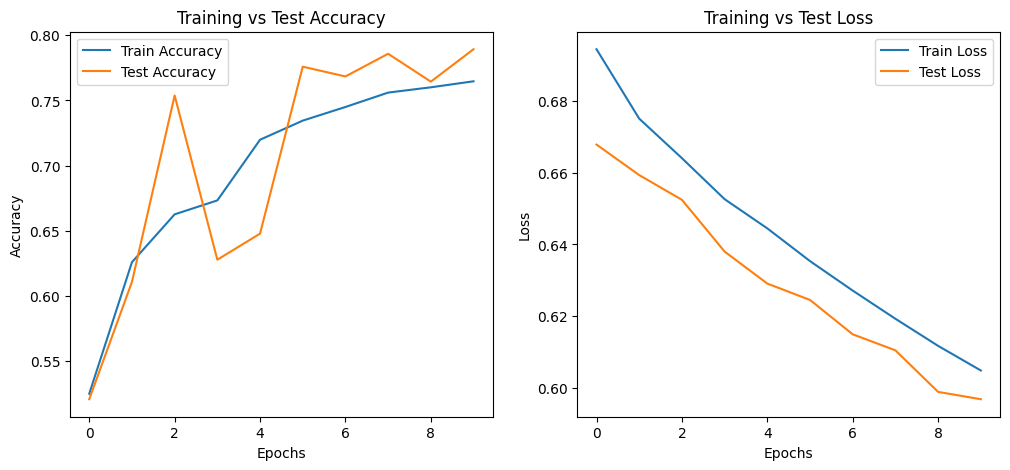

In [ ]:
# Plot training accuracy and loss
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()

plt.show()
